# Importing

In [ ]:
import random
import os
import glob
import time

from google.colab import auth
from google.cloud import storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the Paths for the Raw Cut-out files on my drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd

def get_images_and_labels(base_folder):
    image_paths = []
    image_labels = []

    # Loop through each subfolder
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Loop through each file in the subfolder
            for file in os.listdir(folder_path):
                if file.endswith('.png'):
                    image_paths.append(os.path.join(folder_path, file))
                    image_labels.append(folder_name)

    return image_paths, image_labels

# Name of the base folder
base_folder_name = '/content/drive/MyDrive/CutOutsBrats'

# Get images and labels
image_paths, image_labels = get_images_and_labels(base_folder_name)

# Check if images are found
if not image_paths:
    print("No images found. Please check your dataset path and file types.")
else:
    # Build the DataFrame
    dataset_df = pd.DataFrame({
        'image_path': image_paths,
        'label': image_labels
    })

    # Shuffle and reset the DataFrame
    dataset_df = dataset_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Display the first few rows of the DataFrame
    print(dataset_df.head())


                                          image_path label
0  /content/drive/MyDrive/CutOutsBrats/MEN/BraTS-...   MEN
1  /content/drive/MyDrive/CutOutsBrats/MEN/BraTS-...   MEN
2  /content/drive/MyDrive/CutOutsBrats/GLI/BraTS-...   GLI
3  /content/drive/MyDrive/CutOutsBrats/GLI/BraTS-...   GLI
4  /content/drive/MyDrive/CutOutsBrats/MEN/BraTS-...   MEN


# Inspecting the Data

The classes are imbalanced (MET: 165, MEN: 1000, GLI: 1251). This might bias the model towards classes with more samples. Might consider techniques like oversampling the minority class, undersampling the majority class, or using class weights in the model.

In [ ]:
dataset_df['label'].value_counts().sort_values()

MET     165
MEN    1000
GLI    1251
Name: label, dtype: int64

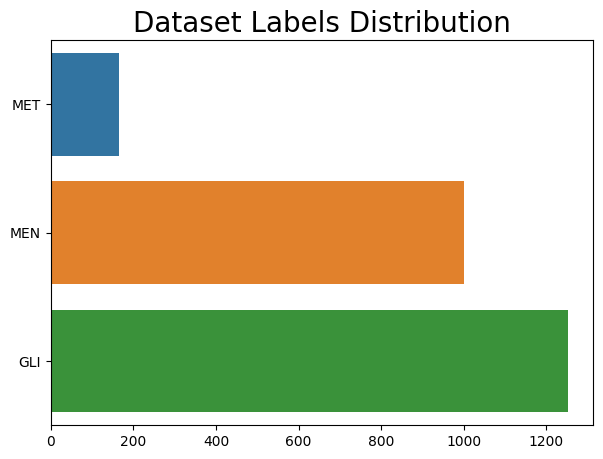

In [ ]:
# Generate Figure
fig = plt.figure(figsize=(7, 5))

# Plot Labels Distribution
plt.title('Dataset Labels Distribution', fontsize=20)
distribution = dataset_df['label'].value_counts().sort_values()
sns.barplot(x=distribution.values,
            y=list(distribution.keys()),
            orient="h");

# Hyperparameters and configurations

In [ ]:

class CFG:
    EPOCHS = 50
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    num_classes = 3

# Encode / Create Train Test Split

In [ ]:
# Generate Label Encoder
label_encoder = LabelEncoder()

# Label Encode the Image Labels
dataset_df['label_encoded'] = label_encoder.fit_transform(dataset_df.label)

# View first 10 samples
dataset_df.head(5)

,image_path,label,label_encoded
0,/content/drive/MyDrive/CutOutsBrats/MEN/BraTS-...,MEN,1
1,/content/drive/MyDrive/CutOutsBrats/MEN/BraTS-...,MEN,1
2,/content/drive/MyDrive/CutOutsBrats/GLI/BraTS-...,GLI,0
3,/content/drive/MyDrive/CutOutsBrats/GLI/BraTS-...,GLI,0
4,/content/drive/MyDrive/CutOutsBrats/MEN/BraTS-...,MEN,1


In [ ]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 3
Classes: ['GLI' 'MEN' 'MET']


In [ ]:
# Create Train/Test split with Training Set
train_split_idx, val_test_split_idx, _, _ = train_test_split(dataset_df.index,
                                                        dataset_df.label_encoded,
                                                        test_size=0.3,
                                                        stratify=dataset_df.label_encoded,
                                                        random_state=CFG.SEED)

In [ ]:
# Get training and validation data
train_df = dataset_df.iloc[train_split_idx].reset_index(drop=True) #reset the index of this new DataFrame. The drop=True argument is important as it prevents the old index from being added as a column in the new DataFrame.
val_test_df = dataset_df.iloc[val_test_split_idx].reset_index(drop=True)

# View shapes
train_df.shape, val_test_df.shape

((1691, 3), (725, 3))

In [ ]:
# Create Train/Test split with Training Set (make just super small test for getting some test similarity search later)
val_split_idx, test_split_idx, _, _ = train_test_split(val_test_df.index,
                                                       val_test_df.label_encoded,
                                                       test_size=0.5,
                                                       stratify=val_test_df.label_encoded,
                                                       random_state=CFG.SEED)

In [ ]:
# Get validation and test data
val_df = dataset_df.iloc[val_split_idx].reset_index(drop=True)
test_df = dataset_df.iloc[test_split_idx].reset_index(drop=True)

# View shapes
val_df.shape, test_df.shape

((362, 3), (363, 3))

In [ ]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}')
print(f'validation samples count:\t{val_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		1691
validation samples count:	362
test samples count:		363
TOTAL:				2416


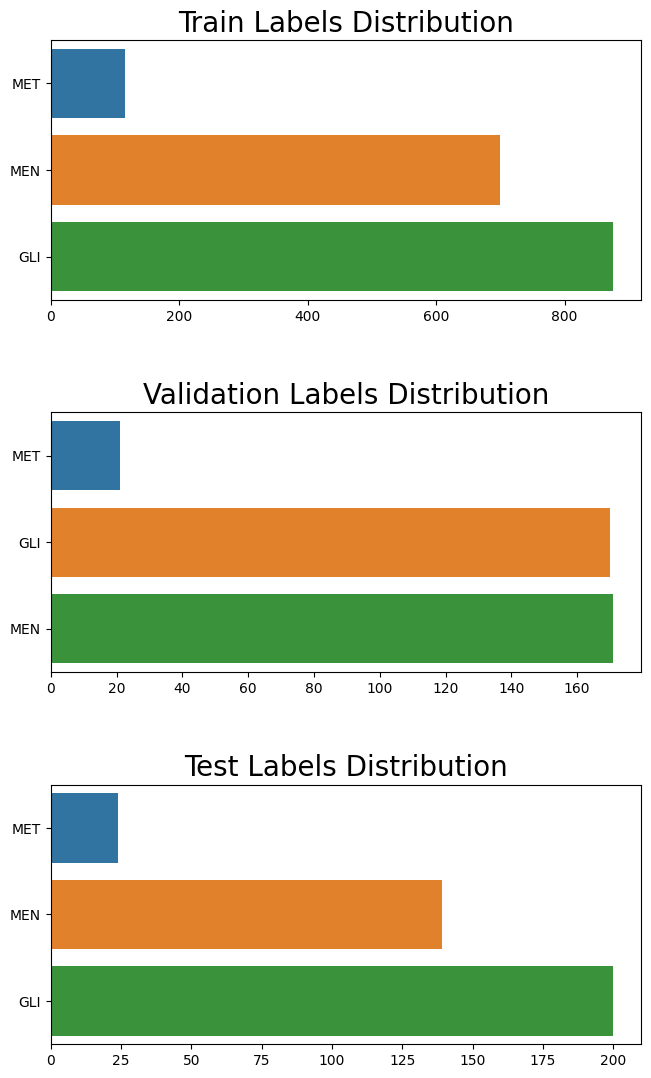

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 12))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1);

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['label'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax3);

In [ ]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)

    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.

    # Return image
    return image

def view_sample(image, label, color_map='gray', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)
    plt.title(f'Label: {label}', fontsize=16)
    return

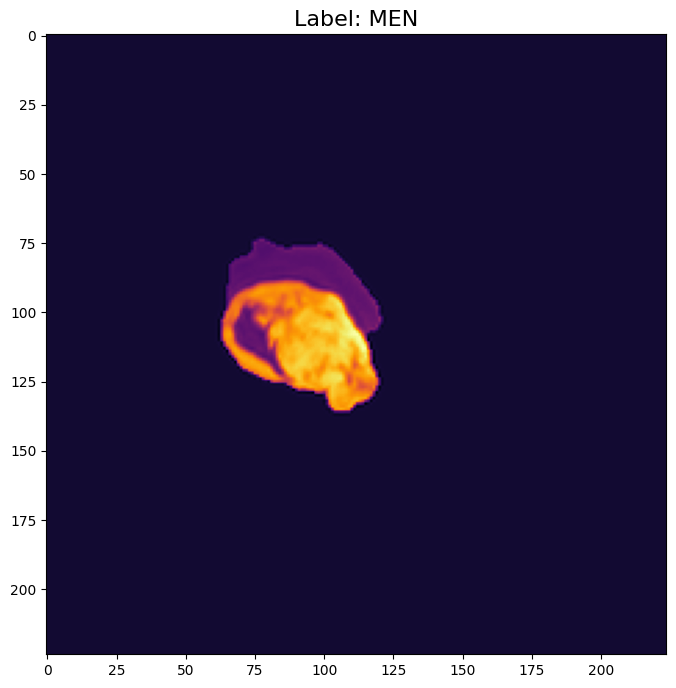

In [ ]:
# Select random sample from train_df
idx = random.sample(dataset_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(dataset_df.image_path[idx]), dataset_df.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='inferno')

# Create an Image Data Augmentation Layer

In [ ]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

# Create Data Input Pipeline

In [ ]:
def encode_labels(labels, encode_depth=CFG.num_classes):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.

    @params
        - df: (pd.DataFrame) -> DataFrame containing paths and labels
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [ ]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_df, _load, augment=True,
                           batch_size=CFG.BATCH_SIZE,
                           shuffle=False, prefetch=True) #the data was presumably shuffled when creating train_df.

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load,
                         batch_size=CFG.BATCH_SIZE,
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load,
                          batch_size=CFG.BATCH_SIZE,
                          shuffle=False, prefetch=False)

In [ ]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_test_df)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

                                             image_path label  label_encoded
0    /content/drive/MyDrive/CutOutsBrats/GLI/BraTS-...   GLI              0
1    /content/drive/MyDrive/CutOutsBrats/MEN/BraTS-...   MEN              1
2    /content/drive/MyDrive/CutOutsBrats/GLI/BraTS-...   GLI              0
3    /content/drive/MyDrive/CutOutsBrats/GLI/BraTS-...   GLI              0
4    /content/drive/MyDrive/CutOutsBrats/MEN/BraTS-...   MEN              1
..                                                 ...   ...            ...
720  /content/drive/MyDrive/CutOutsBrats/GLI/BraTS-...   GLI              0
721  /content/drive/MyDrive/CutOutsBrats/GLI/BraTS-...   GLI              0
722  /content/drive/MyDrive/CutOutsBrats/MEN/BraTS-...   MEN              1
723  /content/driv

# Model


In [ ]:
# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [ ]:
# Get EfficientNet V2 B0 here
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2'
model_name = 'efficientnet_v2_b0'

# Set trainable to False for inference-only
set_trainable=False

efficientnet_v2_b0 = get_tfhub_model(efficientnet_v2_url,
                                     model_name,
                                     model_trainable=set_trainable)

In [ ]:
def efficientnet_v2_model():

    initializer = tf.keras.initializers.GlorotNormal(seed=CFG.SEED)

    efficientnet_v2_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        efficientnet_v2_b0,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(CFG.num_classes, dtype=tf.float32, activation='softmax', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')

    return efficientnet_v2_sequential

In [ ]:
# Generate Model
model_efficientnet_v2 = efficientnet_v2_model()

# Generate Summary of the Model
model_efficientnet_v2.summary()

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b0 (KerasL  (None, 1280)              5919312   
 ayer)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 3)                 771       
                                                                 
Total params: 6707283 (25.59 MB)
Trainable params: 787971 (3.01 MB)
Non-trainable params: 5919312 (2

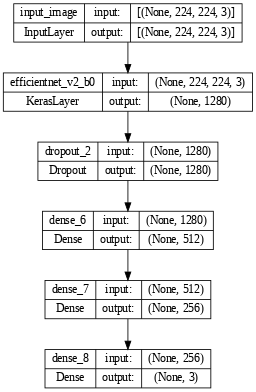

In [ ]:
# Explore model visually
plot_model(
    model_efficientnet_v2, dpi=60,
    show_shapes=True
)

In [ ]:
def train_model(model, num_epochs, callbacks_list, tf_train_data,
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data.

        @params
        - model: (tf.keras.model) -> model to be trained
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)

        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''

    model_history = {}

    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)

    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [ ]:
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)  # ensures that the model weights are rolled back to those of the epoch with the best value of the monitored metric upon early stopping

# Define Reduce Learning Rate Callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [ ]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_efficientnet_v2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model
print(f'Training {model_efficientnet_v2.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_v2_history = train_model(
    model_efficientnet_v2, CFG.EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training efficientnet_v2_sequential_model.
Train on 1691 samples, validate on 362 samples.
----------------------------------
Epoch 1/50
53/53 [==============================] - 256s 5s/step - loss: 0.7718 - accuracy: 0.7469 - val_loss: 0.6315 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 2/50
53/53 [==============================] - 160s 3s/step - loss: 0.4990 - accuracy: 0.8226 - val_loss: 0.4971 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 3/50
53/53 [==============================] - 168s 3s/step - loss: 0.4910 - accuracy: 0.8208 - val_loss: 0.5207 - val_accuracy: 0.8122 - lr: 0.0010
Epoch 4/50
53/53 [==============================] - 155s 3s/step - loss: 0.4551 - accuracy: 0.8362 - val_loss: 0.4623 - val_accuracy: 0.8425 - lr: 0.0010
Epoch 5/50
53/53 [==============================] - 155s 3s/step - loss: 0.4331 - accuracy: 0.8415 - val_loss: 0.4668 - val_accuracy: 0.8425 - lr: 0.0010
Epoch 6/50
53/53 [==============================] - ETA: 0s - loss: 0.4323 - accuracy: 0.8468
Epoch 6: R

In [ ]:
# Save the model in the TensorFlow SavedModel format
model_efficientnet_v2.save('efficientnet_v2_model_brats_cutouts_v2')


In [ ]:
import shutil

# Your Colab folder containing the PNG files and dataset
source_folder = '/content/efficientnet_v2_model_brats_cutouts_v2'

# Path in your Google Drive where you want to copy the files
drive_folder = '/content/drive/MyDrive/CutOutsBrats_cutouts_v2'

# Copy the folder
shutil.copytree(source_folder, drive_folder)


'/content/drive/MyDrive/CutOutsBrats_cutouts_v2'

# load model

In [ ]:
from tensorflow.keras.models import load_model

# Path to the saved model in Google Drive
model_path = '/content/drive/MyDrive/CutOutsBrats_cutouts_v2'

# Load the model
model_efficientnet_v2 = load_model(model_path)


# Feature Extraction

In [ ]:
def efficientnet_v2_feature_extractor():
    feature_layer = model_efficientnet_v2.layers[-2].output #This line extracts the output of the second-to-last layer of the model_efficientnet_v2.
    return tf.keras.Model(inputs=model_efficientnet_v2.input, outputs=feature_layer)

model_feature_extractor = efficientnet_v2_feature_extractor()



In [ ]:
#create a train_ds without augmentation
dataset_nA = create_pipeline(dataset_df, _load, augment=False,
                           batch_size=CFG.BATCH_SIZE,
                           shuffle=False, prefetch=True)

#augment=False ensures that no augmentation is applied to the images. This is important because,
#for generating embeddings, you typically want to use the original images without any modifications that could alter their inherent features.

In [ ]:
#create a train_ds without augmentation
#train_nA = create_pipeline(train_df, _load, augment=False,
 #                          batch_size=CFG.BATCH_SIZE,
  #                         shuffle=False, prefetch=True)


In [ ]:
#create a test_ds without augmentation (doesnt have above but anyways)
test_nA = create_pipeline(test_df, _load, augment=False,
                          batch_size=CFG.BATCH_SIZE,
                        shuffle=False, prefetch=True)

In [ ]:
# Create empty lists to store feature vectors and labels
feature_vectors = []
labels = []

# Iterate over the dataset
for batch, batch_labels in dataset_nA:  # Assuming train_ds_nA yields (image, label) pairs
    batch_features = model_feature_extractor.predict(batch)
    feature_vectors.extend(batch_features)

    # Convert one-hot encoded labels back to label-encoded format
    batch_labels = tf.argmax(batch_labels, axis=1).numpy()  # Find the index of the max value
    labels.extend(batch_labels)




1/1 [==============================] - 2s 2s/step


In [ ]:
# Convert the lists to numpy arrays
feature_vectors = np.array(feature_vectors)
labels_vectors = np.array(labels)

In [ ]:
feature_vectors.shape

(2416, 256)

In [ ]:
labels_vectors.shape

(2416,)

In [ ]:
import pandas as pd
# Convert the feature_vectors array to a DataFrame
df_features = pd.DataFrame(feature_vectors)

# Convert the labels_vectors array to a DataFrame
df_labels = pd.DataFrame(labels_vectors, columns=['Label'])

# Combine the two DataFrames
df = pd.concat([df_features, df_labels], axis=1)

In [ ]:
df.to_pickle("embeddings_EffNV2.pkl")


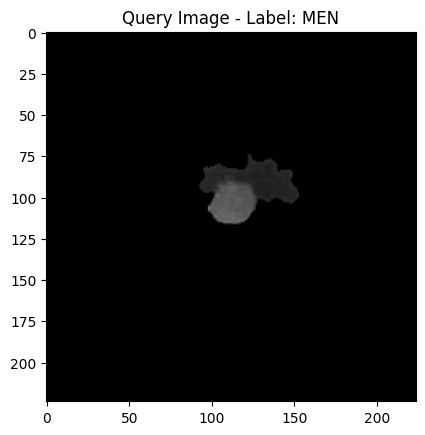

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Take one batch from the validation dataset
for images, labels in test_nA.take(1):
    random_index = random.randint(0, len(images) - 1)
    query_image = images[random_index].numpy()
    query_label = labels[random_index]

    # Normalize the query image
    if query_image.max() > 1:
        query_image /= 255.0

    # Convert one-hot encoded label to label-encoded format
    query_label_encoded = tf.argmax(query_label).numpy()

# Display the query image with its label
plt.imshow(query_image)
plt.title(f"Query Image - Label: {class_names[query_label_encoded]}")
plt.show()


In [ ]:
# Preprocess and extract features of the query image
query_image_processed = tf.expand_dims(query_image, 0)  # Add batch dimension
query_feature = model_feature_extractor.predict(query_image_processed)


1/1 [==============================] - 0s 122ms/step


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate similarities
similarities = cosine_similarity(query_feature, feature_vectors)

# Get the indices of the top 8 similar images
top_8_indices = np.argsort(similarities[0])[-8:][::-1]

# Get the corresponding similarity scores for these indices
top_8_scores = similarities[0][top_8_indices]

# Display the similarity scores
print("Top 8 Similarities:", top_8_scores)

Top 8 Similarities: [1.0000001  0.97809833 0.97379357 0.9731213  0.9721879  0.97189814
 0.9716188  0.9707608 ]


In [ ]:
top_8_indices

array([  27, 1372, 1088, 2121,  303,  151,  136, 1365])

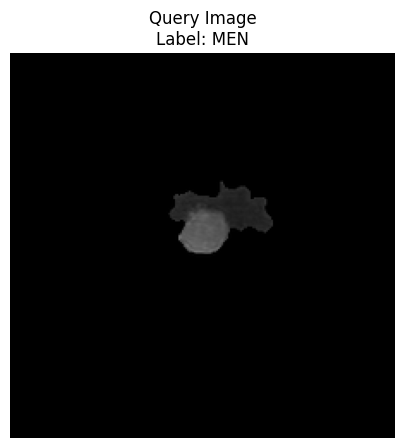

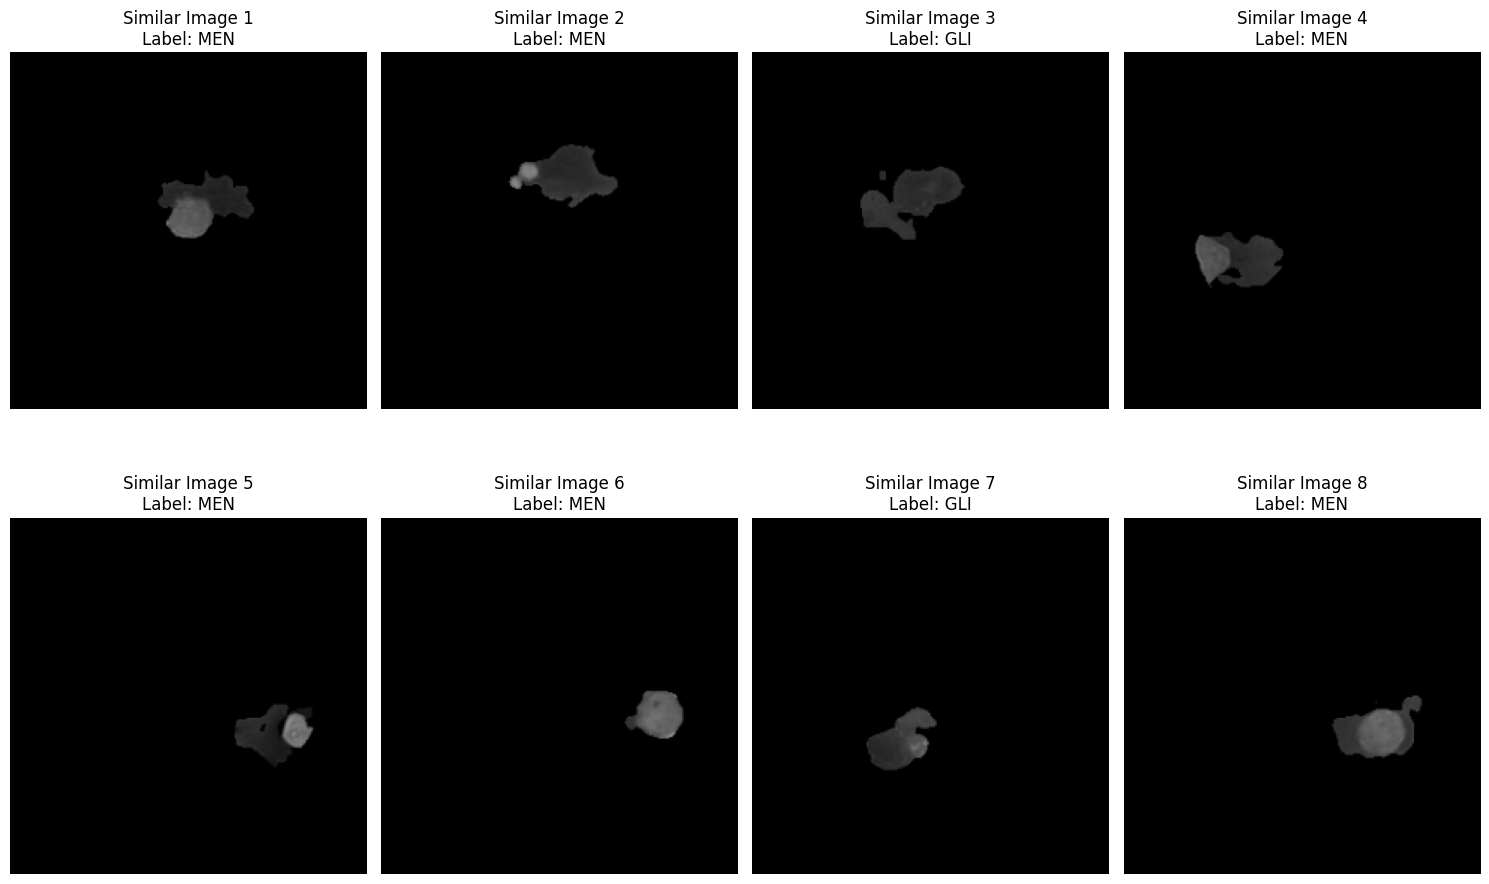

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to load and preprocess an image from a given path
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Adjust based on your image type (e.g., decode_jpeg for JPEG images)
    image = tf.image.resize(image, [224,224])  # Replace with your desired size
    image = image / 255.0  # Normalize to [0, 1] if needed
    return image.numpy()

# Display the query image separately
plt.figure(figsize=(5, 5))
plt.imshow(query_image)
plt.title(f"Query Image\nLabel: {class_names[query_label_encoded]}")
plt.axis('off')
plt.show()

# Assume class_names is a list of unique class labels
# Create a mapping from class names to indices
label_to_index = {label: index for index, label in enumerate(class_names)}

# Display the 8 most similar images in subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# Display the similar images
for i, index in enumerate(top_8_indices, start=1):
    if index < len(dataset_df):
        similar_image_path = dataset_df.iloc[index]['image_path']
        similar_image = load_and_preprocess_image(similar_image_path)
        similar_label = dataset_df.iloc[index]['label']

        # Convert label to its corresponding index
        similar_label_index = label_to_index.get(similar_label, -1)  # Use -1 or any invalid index for not found labels
        if similar_label_index == -1 or similar_label_index >= len(class_names):
            print(f"Label not found or index out of range: {similar_label}")
            continue

        row = (i - 1) // 4
        col = (i - 1) % 4

        axes[row, col].imshow(similar_image)
        axes[row, col].set_title(f"Similar Image {i}\nLabel: {class_names[similar_label_index]}")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Visualize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

df = pd.DataFrame(feature_vectors)
df['category'] = labels_vectors




In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,category
0,0.0,1.273737,0.000000,0.396173,0.388756,0.000000,0.0,0.000000,0.0,0.0,...,0.0,1.826354,0.0,0.150171,1.029603,0.0,0.0,0.0,0.00000,1
1,0.0,0.170349,0.000000,0.000000,0.405616,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.539353,0.0,0.218585,0.000000,0.0,0.0,0.0,0.00000,1
2,0.0,2.332135,0.257204,1.242273,0.686384,0.000000,0.0,0.000000,0.0,0.0,...,0.0,2.637379,0.0,0.392454,2.551547,0.0,0.0,0.0,0.00000,0
3,0.0,2.169309,0.000000,2.125700,0.333229,0.223184,0.0,0.000000,0.0,0.0,...,0.0,3.755983,0.0,0.097525,1.869410,0.0,0.0,0.0,0.00000,0
4,0.0,0.689700,0.000000,0.728253,0.000000,0.000000,0.0,0.382899,0.0,0.0,...,0.0,0.823358,0.0,0.122148,0.000000,0.0,0.0,0.0,2.38338,1


In [ ]:
tsne = TSNE(n_components=2, perplexity=20, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(feature_vectors)  # Use your feature_vectors directly


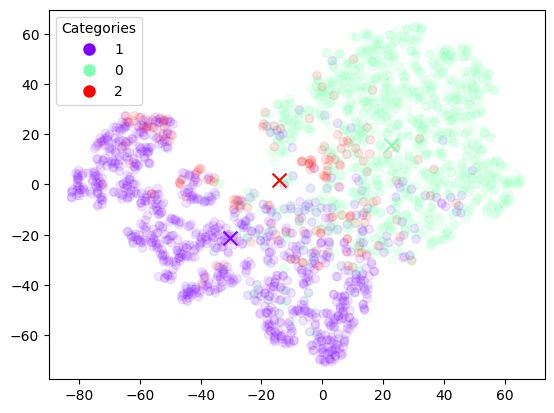

In [ ]:
unique_categories = df['category'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))
category_to_color = dict(zip(unique_categories, colors))

x = [x for x, y in vis_dims]
y = [y for x, y in vis_dims]

color_indices = [category_to_color[category] for category in df['category']]

plt.scatter(x, y, c=color_indices, alpha=0.1)

for category in unique_categories:
    avg_x = np.array(x)[df['category'] == category].mean()
    avg_y = np.array(y)[df['category'] == category].mean()
    plt.scatter(avg_x, avg_y, marker='x', color=category_to_color[category], s=100)

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=category,
                              markerfacecolor=color, markersize=10) for category, color in category_to_color.items()],
          title="Categories")

plt.show()


# Considerations

The feature extractor model you've created will output a dense representation of each image, capturing aspects learned during training. For images of brain tumors, this representation might include patterns, shapes, and textures relevant to the different diagnoses.

Since your model was trained to differentiate between specific diagnoses, its feature representations are optimized for this task. This means that the features it emphasizes and extracts are those that are useful for distinguishing between the different types of tumors.

As a result, the similarity search might be biased towards distinguishing features relevant to the diagnoses rather than other types of similarities that might be visually or contextually relevant.

If the similarity you're interested in aligns well with the distinctions learned during training (i.e., similarities/differences relevant to tumor types), then the model should perform well.

If you're interested in a broader or different type of similarity (e.g., similarities not related to the specific diagnoses), the model might not perform as expected. It might overlook subtle similarities or differences that weren't relevant for the original classification task.


##Further:
Models trained on general datasets like ImageNet are adept at recognizing a wide range of everyday objects and features, but they might lack the specificity required for tasks like distinguishing between different types of brain tumors. Here are some points to consider for your similarity search task:

#### Domain-Specific Features:

Models trained on ImageNet might not capture the nuanced differences in medical images, particularly in specialized fields like neuroimaging. They might treat all brain scans as broadly similar because they lack training on the specific features that differentiate various types of brain tumors.
Your model, trained on MRI brain tumor images, is likely to have learned features specifically relevant to differentiating tumor types. This could make it more effective for a similarity search within this specific domain.
#### Balancing Specificity and Generalization:

The challenge is to find a balance where the model is specific enough to understand the nuances of brain tumors but not so narrowly focused that it only identifies differences relevant to the diagnoses it was trained on.
One approach could be to use a combination of general features (learned from a dataset like ImageNet) and specific features (learned from your tumor dataset). This might involve using a pre-trained model for initial feature extraction and then fine-tuning it on your specific dataset to capture more relevant details.
#### Feature Layer Selection:

The choice of layer from which you extract features can significantly impact performance. Earlier layers in a network capture more general features, while deeper layers capture more specific features. Experimenting with features extracted from different layers could yield better results for your similarity search task.
####Supplementary Techniques:

Consider using dimensionality reduction techniques like PCA (Principal Component Analysis) or t-SNE (t-Distributed Stochastic Neighbor Embedding) on the feature vectors to visualize and understand the feature space your model is using.
Clustering techniques could also help in understanding how the model groups different images and might provide insights into whether the model is focusing on the right features for similarity.
####Continuous Model Improvement:

Continuously updating and refining your model with more diverse and representative data can help improve its ability to discern relevant features for similarity searches.


In **conclusion**, while your model trained on brain tumor images is likely more suitable for a similarity search in this domain than a general-purpose ImageNet model, it's essential to be mindful of the model's biases and limitations. Experimenting with different layers, combining general and specific features, and continuously refining your model can help achieve more accurate and relevant results.









For similarity search, it's generally more appropriate to use feature vectors generated from a validation or test dataset rather than the training dataset. (Would need more data for that) In this case here just the query image was not part of the training.
We would need a larger dataset, and create vector database on images which have not been used in training would be cleaner.

